#**Création d'un modèle pour la suggestion de livres à l'utilisateur**
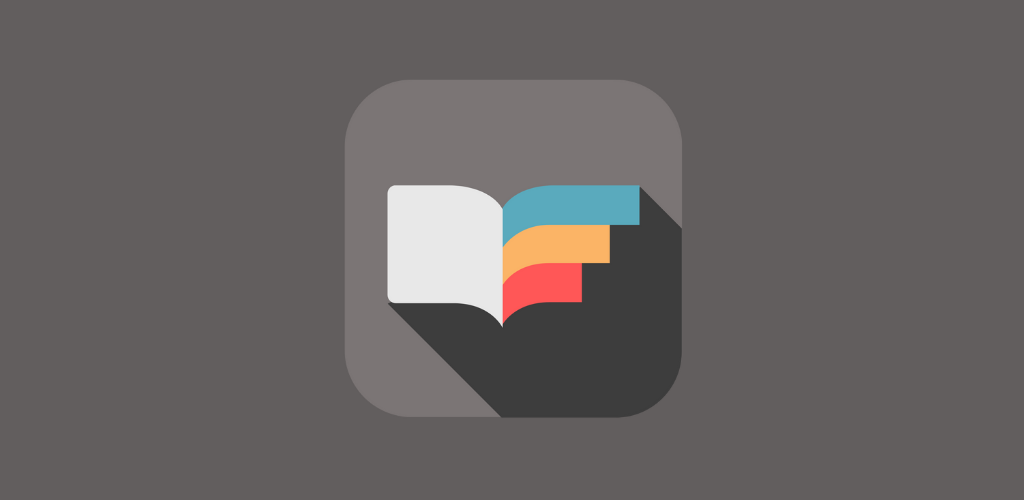










# **Import des données depuis BigQuery**



###**Upload du fichier credentials de BiqQuery**


---


Dans ce notebook, nous utilisons les données analytiques de BigQuery pour générer des données d'entraînement pour notre modèle de recommandations. Pour accéder aux données BigQuery à partir du notebook Colab, vous devez télécharger le fichier de compte de service. ("[ici](https://console.cloud.google.com/iam-admin/iam?authuser=2&project=book-app-7f51e)"). Cependant, par faute de données suffisament importante, nous allons tout d'abord entrainer notre modèle depuis un jeu de données plus conséquent, récupéré depuis Kaggle. 



In [1]:
import os
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():

  with open('/content/' + fn, 'wb') as f:
    f.write(uploaded[fn])
  os.environ["GOOGLE_APPLICATION_CREDENTIALS"]='/content/' + fn
  projectID = fn.rsplit("-", 1)[0]

ModuleNotFoundError: No module named 'google.colab'

##Import des données analytics 

---



Importation des données d'analyse de l'appl depuis BigQuery
Dans cette étape, nous allons charger les données analytiques que nous avons collectées dans l'application avec Firebase Analytics et envoyées à BigQuery. Nous chargerons les données dans la bibliothèque de traitement de données pandas. Les données possèdent déjà le bon format. 

In [ ]:
%load_ext google.cloud.bigquery

Nous utilisons la reqête SQL suivante pour obtenir les éléments de la table que nous avons créée dans BigQuery. Firebase Analytics exporte de nombreuses informations supplémentaires, telles que le type d'appareil, la version de la plateforme, etc. dont nous n'avons pas besoin pour former ce modèle. Pour palier à ce problème, nous traitons les données envoyées par analytics au préalable par un serveur nodeJS.

In [ ]:
%%bigquery analytics_test_import
SELECT
    *
FROM `book-app-7f51e.ml_alldata_app.all_data`

On test notre requête SQL pour vérifier que l'on obtient bien nos données sous le bon format.

In [ ]:
analytics_test_import

In [ ]:
analytics_test_import.columns

On sélectionne les colonnes qui nous intéressent. Dans notre cas nous avons besoin de l'identifiant de l'utilisateur, l'identifiant du livre et la catégorie.

In [ ]:
%%bigquery analytics_data_real
SELECT
    user_id,book_id,category
FROM `book-app-7f51e.ml_alldata_app.all_data`

On sauvegarde nos données dans la variable **analytics**.



In [ ]:
analytics = analytics_data_real
analytics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#**Import des données depuis Kaggle**

###Import et traitement des données depuis le jeu de données Kaggle

Ici nous importons les différents .csv récupérés depuis Kaggle ([ici](https://www.kaggle.com/zygmunt/goodbooks-10k)) afin de créer le modèle.
L'ensemble de données contient environ dix mille livres et un million d'évaluations données par des utilisateurs. Il s'agit d'un jeu de données riche qui peut nous être utile pour ce projet. Pour cela, on upload chaque csv à la racine de notre projet. 

In [ ]:
import os
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  with open('/content/' + fn, 'wb') as f:
    f.write(uploaded[fn])


Ensuite, faisons l'import de toutes les librairies que l'on utilisera au cours de cet apprentissage. Nous importons tout d'abord :  

1.   ***numpy***, qui permet d’effectuer des calculs numériques. Elle introduit une gestion facilitée des tableaux de nombres.

2.   ***pandas*** permet de manipuler facilement des données à analyser, notamment avec la création de dataframes. 

3. ***pyplot*** permet de schématiser nos données sous forme de graphs. 

4. ***os*** permet d'accéder au système d'exploitation et ainsi à notre arborescence. 

5. ***warnings*** On l'utilise afin d'ignorer les warning que l'on génerera, ce qui rendra la lecture des résultats plus lisible.

6. ***tensorflow.keras*** Une api tensorflow basée sur un réseau de neuronnes, permettant de créer et entraîner des modèles de données. 


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow.keras as tf

Tout d'abord, nous extrayons les données des fichiers .csv. 

In [ ]:
ratings_df = pd.read_csv("ratings.csv") 
books_df = pd.read_csv("books.csv")
ratings_df.head()

In [ ]:
books_df.head()


In [ ]:
print(ratings_df.shape)
print(ratings_df.user_id.nunique())
print(ratings_df.book_id.nunique())
ratings_df.isna().sum() #Check si le dataframe est entier et ne contient pas de faux livre avec des infos manquantes.

Comme nous pouvons le voir dans le résultat **ci-dessus**, il y a plus de 900 000 évaluations de livres données par 53 424 utilisateurs pour environ 10 000 livres. Chaque utilisateur a donc évalué plusieurs livres. 

Ici on **split** notre dataframe pour en faire deux jeux : un de test et un d'apprentissage. On prend 30% des 900000 évaluations pour notre jeu de test. 

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest = train_test_split(ratings_df, test_size=0.3, random_state=1)
print(f"Shape of train data: {Xtrain.shape}")
print(f"Shape of test data: {Xtest.shape}")

#**Création du modèle de recommendation**

Créons notre modèle de recommendation en utilisant l'API Keras. Tout d'abord on récupère le nombre de livres dont l'**id** existe et le nombre d'utilisateurs dont l'**id** est non nul. 



---

Nous créons une couche d'entrée pour accepter un tableau d'identifiants de livres, puis nous créons une couche d'intégration avec une forme de (nombre de livres uniques + 1, 15). Nous ajoutons 1 au nombre de livres uniques car les couches d'intégration ont besoin d'une ligne supplémentaire pour les livres qui n'apparaissent pas dans l'ensemble de données d'apprentissage. Ceci peut être appelé les entités hors vocabulaire.
La deuxième dimension est une dimension arbitraire que nous avons choisie. Il peut s'agir d'un nombre quelconque en fonction de la taille de la couche d'intégration que nous souhaitons.

Dans les trois lignes de code suivantes, nous faisons la même chose que pour les livres, mais cette fois pour les utilisateurs.
Dans la ligne de concaténation, nous concaténons ou joignons simplement les couches de livres et d'intégration des utilisateurs, puis nous ajoutons une seule couche dense de 128 nœuds. Pour la dernière couche du réseau, nous utilisons un seul nœud, car nous prédisons les notes données à chaque livre, ce qui ne nécessite qu'un seul nœud.
Dans la dernière ligne de code, nous utilisons la classe tf.Model pour créer un modèle unique à partir de notre architecture définie. Ce modèle attend deux tableaux d'entrée (livres et utilisateurs).



In [ ]:
#Get the number of unique entities in books and users columns
nbook_id = ratings_df.book_id.nunique()
nuser_id = ratings_df.user_id.nunique()
print(nbook_id)
print(nuser_id)

#Book input network
input_books = tf.layers.Input(shape=[1])
embed_books = tf.layers.Embedding(nbook_id + 1,15)(input_books)
books_out = tf.layers.Flatten()(embed_books)

#user input network
input_users = tf.layers.Input(shape=[1])
embed_users = tf.layers.Embedding(nuser_id + 1,15)(input_users)
users_out = tf.layers.Flatten()(embed_users)

conc_layer = tf.layers.Concatenate()([books_out, users_out])
x = tf.layers.Dense(128, activation='relu')(conc_layer)
x_out = x = tf.layers.Dense(1, activation='relu')(x)
model = tf.Model([input_books, input_users], x_out)

On lance notre réseau de neuronne en utilisant les hyperparamètres. Il faudra faire plusieurs tests avant de choisir des paramètres optimisés. 

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

On lance ensuite le **fit** sur le modeèle. La fonction fit attend deux tableaux en entrée. Nous passons donc une liste de livres et d'identifiants d'utilisateurs, ainsi que les évaluations comme cible. 

In [ ]:
hist = model.fit([Xtrain.book_id, Xtrain.user_id], Xtrain.rating, 
                 batch_size=64, 
                 epochs=5, 
                 verbose=1,
                 validation_data=([Xtest.book_id, Xtest.user_id], Xtest.rating))

On lance un plot pour voir si le fit nous sort bien un modèle qui a bien appris.


In [ ]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

In [ ]:
#save the model
model.save('model')

Afin de faire des recommandations, nous devons transmettre la liste des livres et un utilisateur au modèle. Le modèle fera ensuite une prédiction d'une note qu'il pense que l'utilisateur donnera aux livres.
Ces notes sont ensuite triées par ordre de grandeur croissant.

In [ ]:
#Making recommendations for user 100
book_arr = np.array(b_id) #get all book IDs
user = np.array([100 for i in range(len(b_id))])
pred = model.predict([book_arr, user])
pred

Dans la cellule de code ci-dessus, nous obtenons d'abord tous les identifiants de livres et les enregistrons dans un tableau. 

Ensuite, nous créons un autre tableau de la même longueur que le tableau book, mais avec le même ID utilisateur tout au long. Ensuite, nous le transmettons au modèle, qui attend deux entrées (Books et User). Le tableau renvoyé est une liste d'évaluations prévues pour chaque livre.
Ensuite, nous allons trier le tableau et récupérer l'index des 5 plus élevés. Avec cet index, nous pouvons récupérer les livres correspondants du jeu de données :

In [ ]:
pred = pred.reshape(-1) #reshape to single dimension
pred_ids = (-pred).argsort()[0:5]
pred_ids

Enfin, nous utiliserons l'index ( pred_ids) pour récupérer les livres correspondants à partir du DataFrame books.csv :

In [ ]:
books_df.iloc[pred_ids]

On sauvegarde les données sous un format json.

In [ ]:
web_book_data = books_df[["book_id", "title", "image_url", "authors"]]
web_book_data = web_book_data.sort_values('book_id')
web_book_data.head()

Ensuite, nous pouvons l'exporter au format JSON en utilisant la to_jsonfonction dans Pandas.

In [26]:
web_book_data.to_json(r'web_book_data.json', orient='records')

On convertit notre **modèle keras** précedemment créer en un modèle de recommendation javascript. On utilisera ce modèle pour l'utiliser dans notre API Cloud functions en nodeJS.

In [ ]:
!pip install tensorflowjs
!pip install PyInquirer==1.0.3
!tensorflowjs_converter \
    --input_format=keras_saved_model \
    model \
    model_js

#**Export vers le bucket Storage de nos fichiers**

In [ ]:
On initialise notre bucket Storage avec notre identifiant de projet.

In [ ]:
import firebase_admin

firebase_admin.initialize_app(options={'projectId': 'book-app-7f51e', 
             'storageBucket': 'book-app-7f51e' + '.appspot.com' })

On sauvegarde les modèles précedemment crés dans firebase pour y accéder ensuite depuis l'API REST. 

In [41]:
from firebase_admin import storage

bucketName = "gs://book-app-7f51e.appspot.com/ml_data"
bucket = storage.bucket()

blob_json = bucket.blob('ml_data/model_js/model.json')
blob_bin = bucket.blob('ml_data/model_js/group1-shard1of1.bin')
blob_dataset = bucket.blob('ml_data/model_js/web_book_data.json')

output_model = '/content/model_js/model.json'
output_bin = '/content/model_js/group1-shard1of1.bin'
output_dataset = '/content/web_book_data.json'

with open(output_model, 'rb') as my_file:
    blob_json.upload_from_file(my_file)

with open(output_bin, 'rb') as my_file:
    blob_bin.upload_from_file(my_file)

with open(output_dataset, 'rb') as my_file:
    blob_da.upload_from_file(my_file)



#Export vers un fichier tflite (Non utilisée)

In [ ]:
import tensorflow as tf

# Convert the model
saved_model_dir = "/content/model/"
# path to the SavedModel directory
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Save the model.
with open('model/model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
from firebase_admin import ml

# This uploads it to your bucket as recommendation.tflite
source = ml.TFLiteGCSModelSource.from_saved_model('/content/model/')
print (source.gcs_tflite_uri)

In [ ]:
# Create a Model Format
model_format = ml.TFLiteFormat(model_source=source)

# Create a Model object
sdk_model_1 = ml.Model(display_name="recommendations_book_worm", model_format=model_format)

# Make the Create API call to create the model in Firebase
firebase_model_1 = ml.create_model(sdk_model_1)
print(firebase_model_1.as_dict())

# Publish the model
model_id = firebase_model_1.model_id
firebase_model_1 = ml.publish_model(model_id)